#Problem Definition
Given clinical parameters about a patient, can we predict whether or not they have heart disease?

# Features
Explanation of fields in dataset

## Data Dictionary
1. `age` - age in years
2. `sex` - (1 = male; 0 = female)
3. `cp` - chest pain type
    * 0: Typical angina
    * 1: Atypical angina
    * 2: Non-anginal pain
    * 3: Asymptomatic
4. `trestbps` - resting blood pressure (in mm Hg on admission to the hospital) 
5. `chol` - Serum cholesterole in mg/dl
6. `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. `restecg` - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
    * 2: Possible or definite left ventricular hypertrophy
8. `thalach` - maximum heart rate achieved
9. `exang` - exercise induced angina (1 = yes; 0 = no)
10. `oldpeak` - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. `slope` - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. `ca` - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. `thal` - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
14. `target` - have disease or not (1=yes, 0=no) (= the predicted attribute)

# Introduction
First, load the appropriate libraries.

In [ ]:

!pip install -q seaborn

!pip install -q git+https://github.com/tensorflow/docs

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.generic_utils import get_custom_objects

print("Tensorflow sürümü:",tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

     |████████████████████████████████| 1.0MB 4.3MB/s 
Tensorflow sürümü: 2.4.1


In [ ]:
dataset_path = "heart.csv"
column_names = ["Age","Gender","Angina","Rest_BP","Cholesterole","Fasting_BS","ECG","Stress_BPM","SI_Angina","Stress_STDep","Slope", "Colored_Vessels","Thalium","Diagnose"]
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      comment='\t',
                      sep=",", skipinitialspace=True)

df= raw_dataset.copy()
df.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df)

,Age,Gender,Angina,Rest_BP,Cholesterole,Fasting_BS,ECG,Stress_BPM,SI_Angina,Stress_STDep,Slope,Colored_Vessels,Thalium,Diagnose
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              303 non-null    int64  
 1   Gender           303 non-null    int64  
 2   Angina           303 non-null    int64  
 3   Rest_BP          303 non-null    int64  
 4   Cholesterole     303 non-null    int64  
 5   Fasting_BS       303 non-null    int64  
 6   ECG              303 non-null    int64  
 7   Stress_BPM       303 non-null    int64  
 8   SI_Angina        303 non-null    int64  
 9   Stress_STDep     303 non-null    float64
 10  Slope            303 non-null    int64  
 11  Colored_Vessels  303 non-null    int64  
 12  Thalium          303 non-null    int64  
 13  Diagnose         303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
df['Gender'] = df['Gender'].map(lambda x: {0: 'Female', 1: 'Male'}.get(x))
df['Angina'] = df['Angina'].map(lambda x: {0: 'Angina', 1: 'Atypical_Angina', 2: 'Non-Anginal'}.get(x))
df['Slope'] = df['Slope'].map(lambda x: {0: 'Upsloping', 1: 'Flatsloping', 2: 'Downsloping'}.get(x))
df['Thalium'] = df['Thalium'].map(lambda x: {6: 'Thalium_Fixed', 7: 'Thalium_Reversable'}.get(x))

df = pd.get_dummies(df, prefix='', prefix_sep='')
df.head()

,Age,Rest_BP,Cholesterole,Fasting_BS,ECG,Stress_BPM,SI_Angina,Stress_STDep,Colored_Vessels,Diagnose,Female,Male,Angina,Atypical_Angina,Non-Anginal,Downsloping,Flatsloping,Upsloping
0,63,145,233,1,0,150,0,2.3,0,1,0,1,0,0,0,0,0,1
1,37,130,250,0,1,187,0,3.5,0,1,0,1,0,0,1,0,0,1
2,41,130,204,0,0,172,0,1.4,0,1,1,0,0,1,0,1,0,0
3,56,120,236,0,1,178,0,0.8,0,1,0,1,0,1,0,1,0,0
4,57,120,354,0,1,163,1,0.6,0,1,1,0,1,0,0,1,0,0


In [ ]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

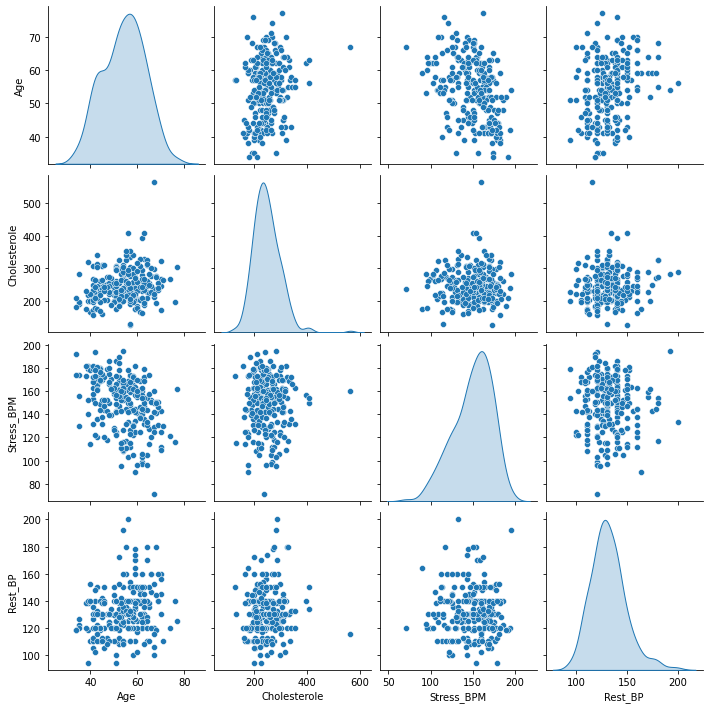

In [ ]:
sns.pairplot(train_dataset[["Age", "Cholesterole", "Stress_BPM", "Rest_BP"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("Diagnose")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Age,242.0,54.128099,8.904992,34.0,48.0,54.5,60.75,77.0
Rest_BP,242.0,131.396694,17.352331,94.0,120.0,130.0,140.00,200.0
Cholesterole,242.0,247.181818,51.235037,126.0,212.0,241.5,274.00,564.0
Fasting_BS,242.0,0.144628,0.352454,0.0,0.0,0.0,0.00,1.0
ECG,242.0,0.528926,0.516522,0.0,0.0,1.0,1.00,2.0
Stress_BPM,242.0,149.797521,22.935873,71.0,134.5,153.0,167.75,195.0
SI_Angina,242.0,0.330579,0.471396,0.0,0.0,0.0,1.00,1.0
Stress_STDep,242.0,0.991322,1.162148,0.0,0.0,0.6,1.60,6.2
Colored_Vessels,242.0,0.685950,0.985649,0.0,0.0,0.0,1.00,4.0
Female,242.0,0.314050,0.465098,0.0,0.0,0.0,1.00,1.0


In [ ]:
train_labels = train_dataset.pop('Diagnose')
test_labels = test_dataset.pop('Diagnose')

# Normalize Data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Building Model

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=[len(train_dataset.keys())]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1, activation='sigmoid'),
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 4,049
Trainable params: 4,049
Non-trainable params: 0
_________________________________________________________________


Try short batch

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.33607644],
       [0.60434824],
       [0.59089565],
       [0.376843  ],
       [0.7158791 ],
       [0.51122624],
       [0.41675228],
       [0.47256494],
       [0.3845768 ],
       [0.4450603 ]], dtype=float32)

In [ ]:
EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1899,  mae:0.4021,  mse:0.1899,  val_loss:0.1434,  val_mae:0.3350,  val_mse:0.1434,  
....................................................................................................
Epoch: 100, loss:0.0187,  mae:0.0442,  mse:0.0187,  val_loss:0.1390,  val_mae:0.1934,  val_mse:0.1390,  
....................................................................................................
Epoch: 200, loss:0.0107,  mae:0.0166,  mse:0.0107,  val_loss:0.1576,  val_mae:0.1825,  val_mse:0.1576,  
....................................................................................................
Epoch: 300, loss:0.0104,  mae:0.0109,  mse:0.0104,  val_loss:0.1832,  val_mae:0.2092,  val_mse:0.1832,  
....................................................................................................
Epoch: 400, loss:0.0006,  mae:0.0051,  mse:0.0006,  val_loss:0.1858,  val_mae:0.2233,  val_mse:0.1858,  
........................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,1.028576e-08,0.000065,1.028576e-08,0.165063,0.183910,0.165063,495
496,9.839557e-09,0.000064,9.839557e-09,0.165702,0.184701,0.165702,496
497,9.595059e-09,0.000063,9.595059e-09,0.170873,0.189397,0.170873,497
498,9.620760e-09,0.000063,9.620760e-09,0.168751,0.187135,0.168751,498
499,8.796142e-09,0.000061,8.796142e-09,0.166396,0.184456,0.166396,499


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

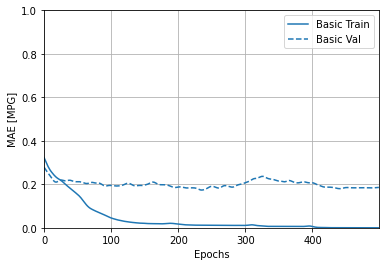

In [ ]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

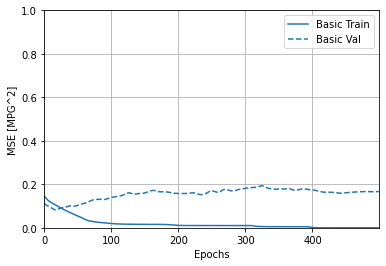

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 1])
plt.ylabel('MSE [MPG^2]')

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1891,  mae:0.4048,  mse:0.1891,  val_loss:0.1221,  val_mae:0.3098,  val_mse:0.1221,  
............................................................

Text(0, 0.5, 'MAE [MPG]')

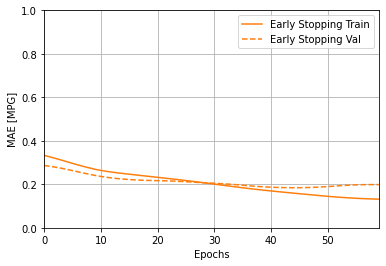

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE [MPG]')

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

2/2 - 0s - loss: 0.0825 - mae: 0.1771 - mse: 0.0825
Testing set Mean Abs Error:  0.18 MPG


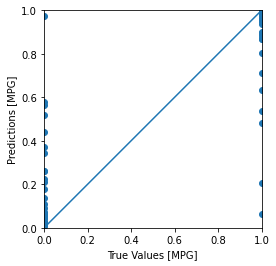

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


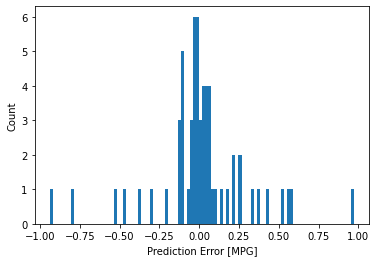

In [ ]:

error = test_predictions - test_labels
plt.hist(error, bins = 100)

plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:

print(np.mean(error))
print(np.std(error))
print(len(error))
model.save('trained_model.h5')

0.015189613963736862
0.2867838259142971
61


In [ ]:
test_dataset_merged = pd.DataFrame(test_labels, columns=['Diagnose'])
#test_dataset_merged['Diagnose'] = test_labels
test_dataset_merged['Prediction'] = test_predictions

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test_dataset_merged)

     Diagnose  Prediction
1           1    0.806080
9           1    0.950018
17          1    0.889261
25          1    0.480342
28          1    0.962861
31          1    0.897916
32          1    0.949526
35          1    0.936567
38          1    0.971934
39          1    0.887534
42          1    0.204143
47          1    0.966824
53          1    0.995625
57          1    0.538742
65          1    0.983002
70          1    0.634007
72          1    0.871078
79          1    0.899681
87          1    0.981623
88          1    0.993496
99          1    0.710696
105         1    0.949082
115         1    0.993666
117         1    0.868713
120         1    0.062011
127         1    0.972959
128         1    0.990580
132         1    0.978256
147         1    0.979065
151         1    0.867520
163         1    0.890054
165         0    0.015479
169         0    0.211772
172         0    0.565862
174         0    0.014952
177         0    0.438362
183         0    0.136230
185         